## Model Performance for ABM Data

All models are trained on data from fall 2016, 2017 and 2018. Hyperparameters have been tuned using data from fall 2019.

The final model performance is evaluated on data from fall 2015.

Model performance is quantified using the Root Mean-Squared Error (RMSE), where only available timepoints during the night are considered.

### Overview of models
#### **Site-specific**

Site-specific models are different for every radar station.
- Historical average (HA), bird density at radar station averaged over training years
- Generalized additive Models (GAM) based on `day of the year`, `solar position` and `change in solar position`

#### **Local models**

Local models don't take spatial or temporal dependencies into account
- Gradient Boosted Regression Trees (GBT)
- Multi-Layer Perceptron (MLP)

Features used: `radar coordinates`, `Voronoi area`, `u & v wind component`, `cloud cover`, `total precipitation`, `surface pressure`, `surface temperature`, `sensible heat flux`

#### **Temporal models**

Temporal models are recurrent models that predict future bird densities based on previous timesteps, but don't take spatial dependencies into account
- Long-Short Term Memory (LocalLSTM)

Additional features used: `dusk (boolean)`, `dawn (boolean)`, `bird density at previous timestep`

#### **Spatio-temporal models**

Spatio-temporal models take both spatial and temporal dependencies into account
- graph neural network based on Voronoi tessellation with recurrent component (GraphLSTM)
    - prediction = `total flux from/to neighbors` + `bird density at previous timestep` + `delta`
- graph nerual network based on Voronoi tessellation with recurrent component and explicitly modelled bird flows between adjacent radar stations (BirdFlowGraphLSTM)
    - prediction = `sum of in-fluxes from neighbors` + `flux to self` + `delta`

Features for spatial component: `radar coordinates`, `environment variables (see above)`, `radar distance`, `radar angle`, `length of Voronoi face`, `bird density at previous timestep`

Features for temporal component: `radar coornidates`, `environment variables (see above)`, `dusk (boolean)`, `dawn (boolean)`, `Voronoi area`, `bird density at previous timestep`

![alt text](../data/plots/presentations/GNN_overview.png "Spatio-Temporal Graph Neural-Net")

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import torch
import os.path as osp
import seaborn as sb
from matplotlib import pyplot as plt
import glob
import utils
from yaml import Loader, load
import pickle5 as pickle
from matplotlib import cm

In [2]:
base_dir = '/home/fiona/birdMigration/results/abm'

### Load Results

In [5]:
models = ['HA', 'GAM', 'GBT', 'LocalMLP', 'LocalLSTM', 'BirdFlowGraphLSTM'] #, 'GraphLSTM']
experiments = ['', '', '_not_transformed', '_not_transformed', '_new', '_new', '_new']
results = dict()
bird_scales = dict()
for i, m in enumerate(models):
    if m in ['HA', 'GAM']:
        experiment = 'radar_specific'
    else:
        experiment = 'best_settings' + experiments[i]
    
    # load predictions
    model_dir = osp.join(base_dir, 'testing', m, experiment)
    files = glob.glob(model_dir + "/**/results.csv", recursive = True)
    print(files)
    results[m] = pd.read_csv(files[0])
    
    # load bird scales
    fp = osp.join(base_dir, 'training', m, experiment, 'config.yaml')
    with open(fp) as f:
        cfg = load(f, Loader=Loader)
    bird_scales[m] = cfg['datasource']['bird_scale']
    
    # load outfluxes
    if m == 'BirdFlowGraphLSTM':
        files = glob.glob(model_dir + "/**/outfluxes_abs_*.pickle", recursive = True)
        outfluxes = dict()
        for r, file in enumerate(files):
            with open(file, 'rb') as f:
                outfluxes[r] = pickle.load(f)

['/home/fiona/birdMigration/results/abm/testing/HA/radar_specific/results.csv']
['/home/fiona/birdMigration/results/abm/testing/GAM/radar_specific/results.csv']
['/home/fiona/birdMigration/results/abm/testing/GBT/best_settings_not_transformed/{"n_estimators": 100, "lr": 0.05, "max_depth": 6}/results.csv']
['/home/fiona/birdMigration/results/abm/testing/LocalMLP/best_settings_not_transformed/{"n_hidden": 128, "n_layers": 2, "dropout_p": 0.25, "lr": 0.001, "lr_decay": 50}/results.csv']
['/home/fiona/birdMigration/results/abm/testing/LocalLSTM/best_settings_new/{"n_hidden": 128, "n_layers": 1, "dropout_p": 0.25, "lr": 0.001, "lr_decay": 50, "teacher_forcing_gamma": 0.9, "predict_delta": true}/results.csv']
[]


IndexError: list index out of range

### Load results for models trained on data from radar buffers

In [ ]:
models = ['HA', 'GAM', 'GBT', 'LocalMLP', 'LocalLSTM', 'BirdFlowGraphLSTM'] #, 'GraphLSTM']
experiments = ['', '', '_not_transformed_use_buffers', '_not_transformed_use_buffers', '_use_buffers', '_use_buffers', '_use_buffers']
results_buffers = dict()
bird_scales_buffers = dict()
for i, m in enumerate(models):
    if m in ['HA', 'GAM']:
        experiment = 'radar_specific'
    else:
        experiment = 'best_settings' + experiments[i]
    
    # load predictions
    model_dir = osp.join(base_dir, 'testing', m, experiment)
    files = glob.glob(model_dir + "/**/results.csv", recursive = True)
    results_buffers[m] = pd.read_csv(files[0])
    
    # load bird scales
    fp = osp.join(base_dir, 'training', m, experiment, 'config.yaml')
    with open(fp) as f:
        cfg = load(f, Loader=Loader)
    bird_scales_buffers[m] = cfg['datasource']['bird_scale']

### Radar observations vs. predicted bird density for **raw data**

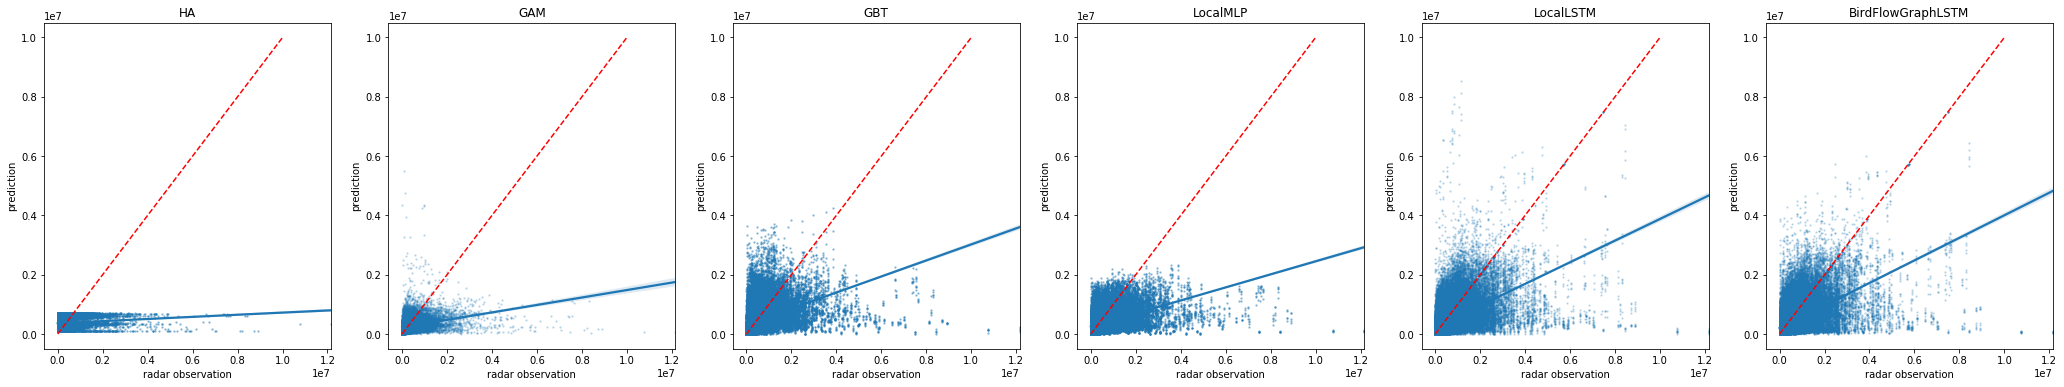

In [5]:
fig = utils.plot_results_scatter(results)

### Radar observations vs. predicted bird density for **power-transformed data with exponent p=1/3**

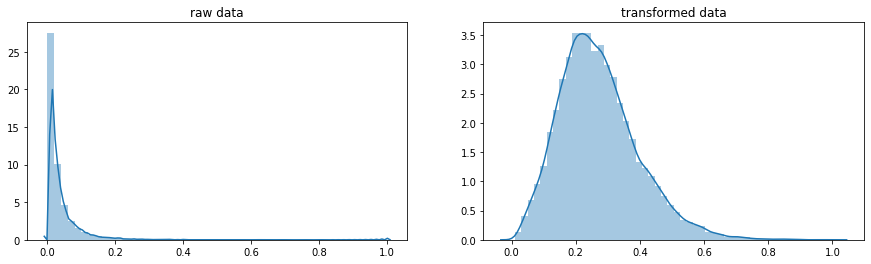

In [12]:
p = 1/3
data = results['HA'].query('night == True & missing == False & gt > 0')['gt'].values
data_transformed = np.power(data, p)
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
sb.distplot(data / np.nanmax(data), ax= ax[0])
sb.distplot(data_transformed / np.nanmax(data_transformed), ax= ax[1])
ax[0].set_title('raw data')
ax[1].set_title('transformed data');

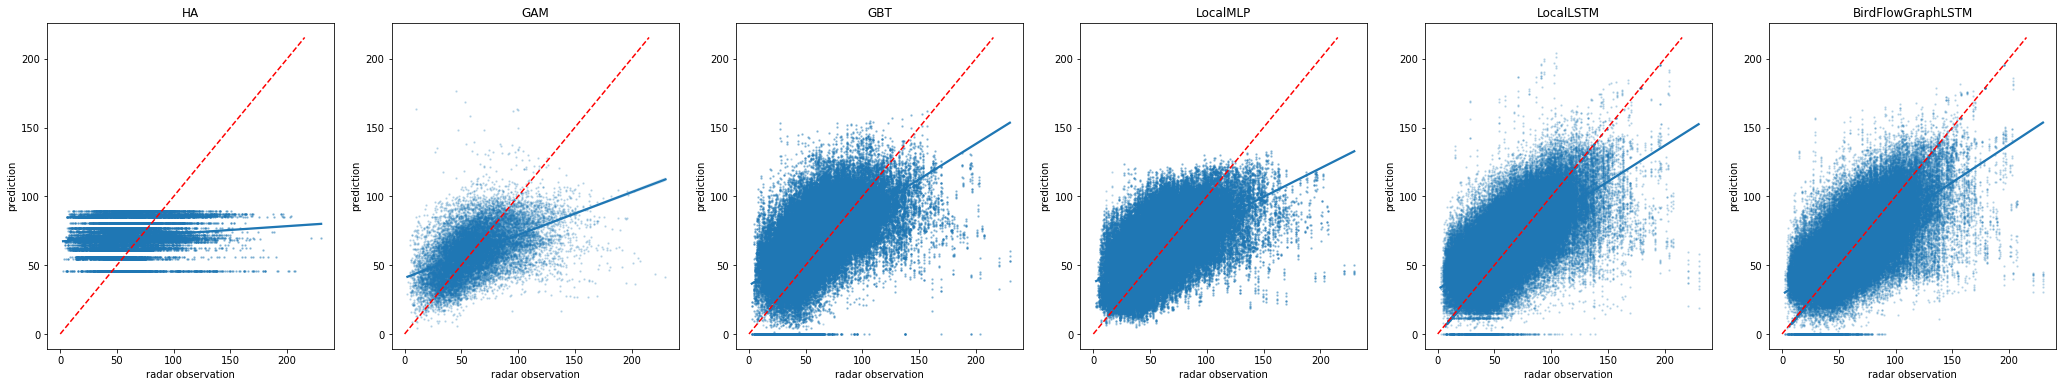

In [6]:
fig = utils.plot_results_scatter(results, root_transform=3)

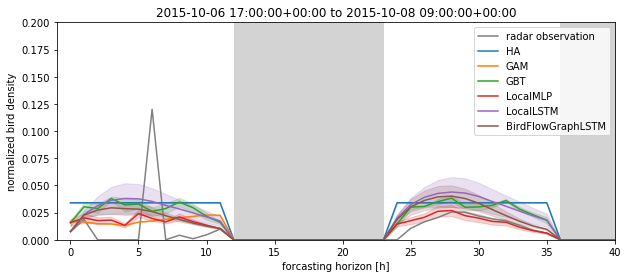

In [7]:
fig = utils.plot_example_prediction(results, 'dehnr', seqID=40, bird_scales=bird_scales, max=0.2)

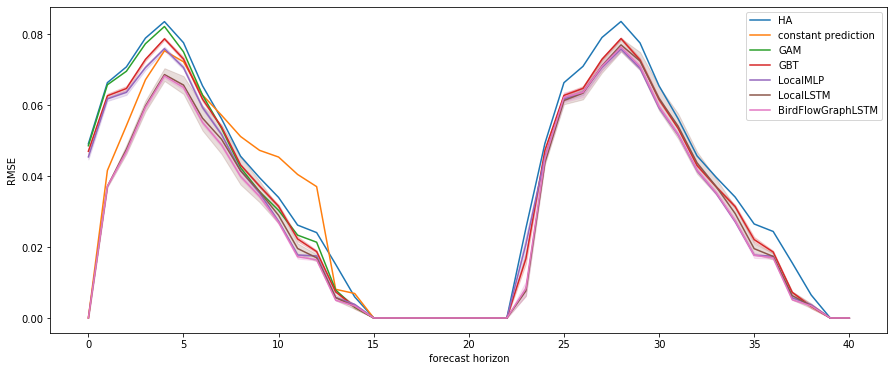

In [4]:
fig = utils.plot_errors(results, bird_scales)

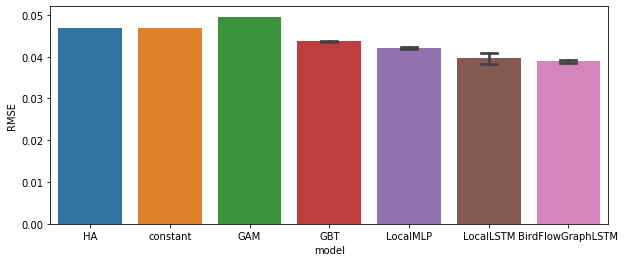

In [4]:
fig = utils.plot_average_errors(results, bird_scales)

Error bars show the standard deviation in RMSE over 5 repeatedly trained models using different random seeds

## Analysis of BirdFlowGraphLSTM
### Inferred outflux per radar station
The outflux per radar station should equal to 1 at each timestep if no birds are landing and thus moving from the air to the ground.

[Text(0, 0.5, 'total outflux')]

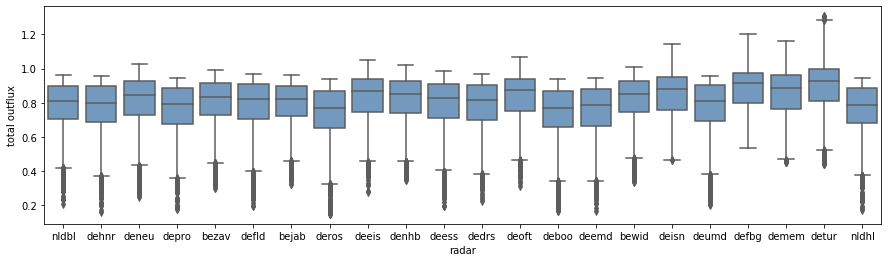

In [41]:
fig, ax = plt.subplots(figsize=(15, 4))
sb.boxplot(x='radar', y='outflux', data=results['BirdFlowGraphLSTM'].query('night == True & horizon != 0'), ax=ax, color='#6699cc') #, ci='sd')
ax.set(ylabel='total outflux')

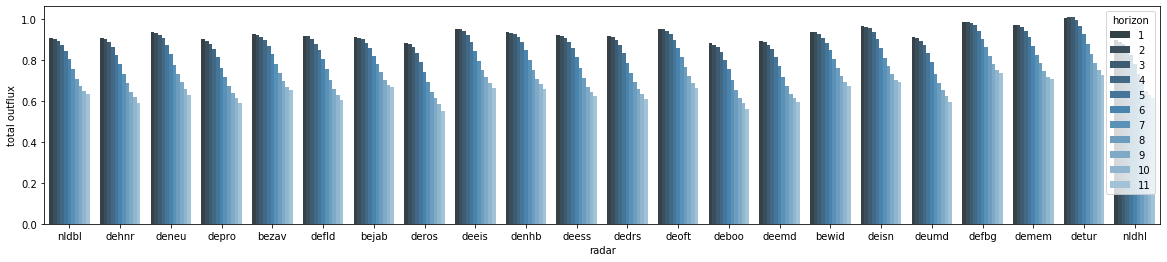

In [28]:
fig, ax = plt.subplots(figsize=(20, 4))
sb.barplot(x='radar', y='outflux', hue='horizon', data=results['BirdFlowGraphLSTM'].query('night == True & horizon != 0 & horizon < 12'), 
           ax=ax, ci=None, palette="Blues_d")
ax.set(ylabel='total outflux');

### Inferred number of birds taking off / landing per radar station
If delta < 0, more birds are landing than taking off. Otherwise, more birds are taking off.

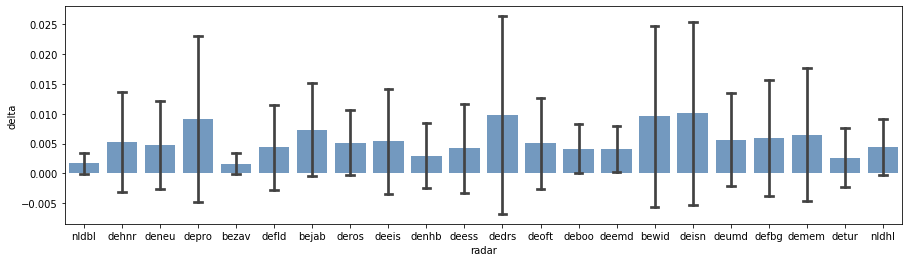

In [46]:
fig, ax = plt.subplots(figsize=(15, 4))
sb.barplot(x='radar', y='delta', data=results['BirdFlowGraphLSTM'].query('night == True & horizon != 0'), ax=ax, color='#6699cc', capsize=.2, ci='sd')

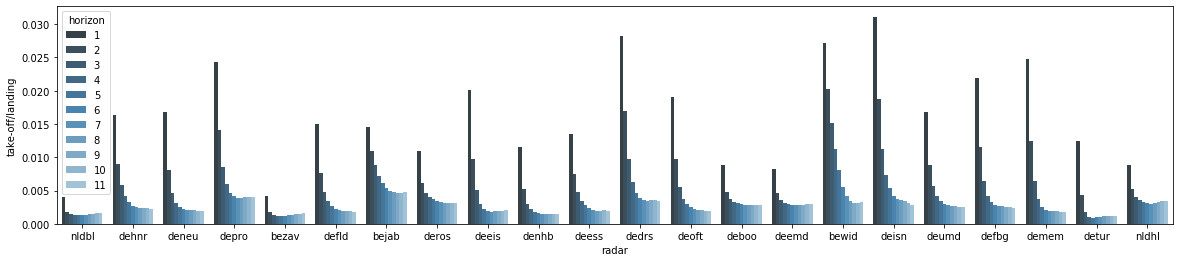

In [29]:
fig, ax = plt.subplots(figsize=(20, 4))
sb.barplot(x='radar', y='delta', hue='horizon', data=results['BirdFlowGraphLSTM'].query('night == True & horizon != 0 & horizon < 12'), 
           ax=ax, ci=None, palette="Blues_d")
ax.set(ylabel='take-off/landing');